In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from preprocess import make_dataset, scale_IR
import torch.optim as optim
from model import *
from torch.utils.data import Dataset, DataLoader


In [2]:
class CustomDataset(Dataset):
    def __init__(self, distance_dataset, IR_dataset, ground_truth, filename_dataset):
        self.IR_dataset = IR_dataset
        self.distance_dataset = distance_dataset
        self.ground_truth = ground_truth
        self.filename_dataset = filename_dataset

    def __len__(self):
        return self.IR_dataset.shape[0]

    def __getitem__(self, idx):
        IR_data = self.IR_dataset[idx]
        distance_data = self.distance_dataset[idx]
        label = self.ground_truth[idx]
        # 将标签转换为one-hot编码
        label_one_hot = torch.zeros(LABEL_NUM)
        label_one_hot[label] = 1
        return IR_data, distance_data, label_one_hot, self.filename_dataset[idx]


In [3]:
trainset, testset = make_dataset()

# 创建数据集和数据加载器
train_dataset = CustomDataset(*trainset)
test_dataset = CustomDataset(*testset)

# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)


distance length is 235
IR length is 235
gt length is 235
Distance train dataset: torch.Size([816, 14, 1])
IR train dataset: torch.Size([816, 9, 64])
gt train dataset: 816
test dataset has file amount:  torch.Size([70, 14, 1])


In [4]:

# 实例化网络
net = MyMLP().to(mydevice)
# net = MyCNN().to(mydevice)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [5]:
loss_history = []
# 训练循环示例
for epoch in range(800):
    running_loss = 0.0
    for i, (IR_data, distance_data, labels, _) in enumerate(train_dataloader, 0):
        IR_data = IR_data.to(mydevice)
        distance_data = distance_data.to(mydevice)
        labels = labels.to(mydevice)
        # 清零梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = net(IR_data, distance_data)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新权重
        optimizer.step()

        # 打印统计信息
        running_loss += loss.cpu().item()
        if i % 20 == 19:  # 每10个批次打印一次
            loss_mean = running_loss / 20
            loss_history.append(loss_mean)
            print(f"[{epoch + 1}, {i + 1}] loss: {loss_mean:.3f}")
            running_loss = 0.0


[1, 20] loss: 1.624
[1, 40] loss: 1.596
[1, 60] loss: 1.566
[1, 80] loss: 1.492
[1, 100] loss: 1.522
[1, 120] loss: 1.507
[1, 140] loss: 1.534
[1, 160] loss: 1.529
[2, 20] loss: 1.522
[2, 40] loss: 1.529
[2, 60] loss: 1.513
[2, 80] loss: 1.482
[2, 100] loss: 1.437
[2, 120] loss: 1.516
[2, 140] loss: 1.485
[2, 160] loss: 1.507
[3, 20] loss: 1.471
[3, 40] loss: 1.558
[3, 60] loss: 1.438
[3, 80] loss: 1.486
[3, 100] loss: 1.520
[3, 120] loss: 1.449
[3, 140] loss: 1.447
[3, 160] loss: 1.391
[4, 20] loss: 1.476
[4, 40] loss: 1.431
[4, 60] loss: 1.437
[4, 80] loss: 1.401
[4, 100] loss: 1.425
[4, 120] loss: 1.412
[4, 140] loss: 1.401
[4, 160] loss: 1.397
[5, 20] loss: 1.369
[5, 40] loss: 1.427
[5, 60] loss: 1.424
[5, 80] loss: 1.363
[5, 100] loss: 1.362
[5, 120] loss: 1.354
[5, 140] loss: 1.364
[5, 160] loss: 1.357
[6, 20] loss: 1.356
[6, 40] loss: 1.336
[6, 60] loss: 1.345
[6, 80] loss: 1.330
[6, 100] loss: 1.367
[6, 120] loss: 1.348
[6, 140] loss: 1.334
[6, 160] loss: 1.365
[7, 20] loss: 1.

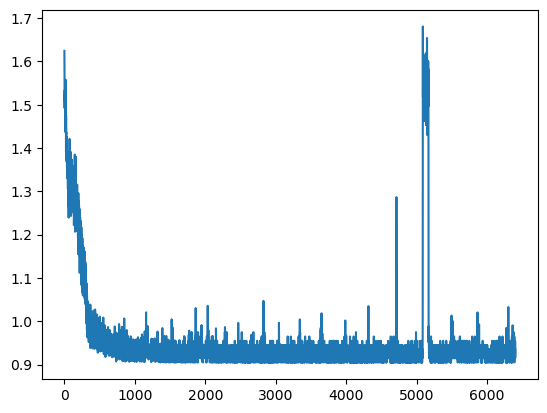

In [6]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.show()

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 测试循环
true_labels = []
predicted_labels = []
filenames = []
with torch.no_grad():
    for i, (IR_data, distance_data, labels, filename) in enumerate(test_dataloader):
        IR_data = IR_data.to(mydevice)
        distance_data = distance_data.to(mydevice)

        outputs = net(IR_data, distance_data)
        outputs = outputs.cpu()

        _, predicted = torch.max(outputs.data, 1)
        _, gt = torch.max(labels.data, 1)
        
        true_labels.extend(gt.numpy())
        predicted_labels.extend(predicted.numpy())
        filenames += filename

# 计算性能指标
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1) # macro
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}\n")

# 计算每个类别的精确度和召回率
precision_per_class = precision_score(true_labels, predicted_labels, average=None, zero_division=0)
recall_per_class = recall_score(true_labels, predicted_labels, average=None, zero_division=0)

# 打印结果
print("labels are ", ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit'])
print(f"Precision per class: {precision_per_class}")
print(f"Recall per class: {recall_per_class}\n")

from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels)

print("混淆矩阵:")
print(cm)

Accuracy: 0.8571
Precision: 0.8639
Recall: 0.8571

labels are  ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit']
Precision per class: [0.66666667 0.90909091 0.88888889 0.85714286 0.83333333]
Recall per class: [1.         0.95238095 0.66666667 0.7826087  1.        ]

混淆矩阵:
[[ 4  0  0  0  0]
 [ 0 20  1  0  0]
 [ 0  1  8  3  0]
 [ 2  1  0 18  2]
 [ 0  0  0  0 10]]


In [8]:
# 找出被错误分类的样本
misclassified_samples = [filenames[i] for i in range(len(filenames)) if true_labels[i] != predicted_labels[i]]
print("被错误分类的样本:", misclassified_samples)

被错误分类的样本: ['high-position-stand_1712651209', 'high-position-sit2stand_1712651303', 'high-position-stand_1712648384', 'high-position-stand_1712651227', 'high-position-sit2stand_1712650178', 'high-position-stand_1712645386', 'high-position-sit2stand_1712652262', 'high-position-sit2stand_1712647586', 'high-position-stand_1712651218', 'high-position-sit_1712647049']


In [9]:
import shutil
import os
from datetime import datetime
from pathlib import Path

# 创建目标文件夹
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
target_folder = os.path.join("wrongs", timestamp)
os.makedirs(target_folder, exist_ok=True)

# 复制被错误分类的样本到目标文件夹
for filename in misclassified_samples:
    # 假设原始文件位于当前文件夹中
    folder, sample_id = filename.split('_')
    source_path = Path('..') / 'data_v2' / folder / f'{sample_id}.mp4'
    # target_path = os.path.join(target_folder, os.path.basename(filename))
    shutil.copy(source_path, target_folder)

print(f"被错误分类的样本已复制到 {target_folder}")


被错误分类的样本已复制到 wrongs/20240410-102520


In [10]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

Total parameters: 3165


In [10]:
torch.save(net.state_dict(), 'checkpoints_v2/high/F9-14-MLP221-Fea4-24-gap32-miniFilter-0d86.pth')